In [1]:
import sys
sys.path.append('/cluster/sj1')

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
import numpy as np
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from bb_opt.src.bayesian_opt import (
    optimize,
    get_model_bnn,
    get_model_bnn_laplace,
    train_model_bnn,
    partial_train_model_bnn,
    train,
    bnn_predict
)
from bb_opt.src.utils import get_path, save_pyro_model, load_pyro_model
from gpu_utils.utils import gpu_init
import torch.distributions as tdist
from tqdm import tnrange

gpu_id = gpu_init(best_gpu_metric="mem")
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

Running on GPU 2


In [23]:
from bb_opt.src.bayesian_opt import get_model_bnn_extended_gamma

In [3]:
def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    #ax = sns.regplot(predicted, true)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

In [4]:
n_train = 100

project = "dna_binding"
dataset = "crx_ref_r1"
batch_size = 1
retrain_every = 1000000
partial_steps = 20

root = "/cluster/sj1/bb_opt/"
data_dir = get_path(root, "data", project, dataset)
inputs = np.load(get_path(data_dir, "inputs.npy"))
labels = np.load(get_path(data_dir, "labels.npy"))
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=n_train, random_state=521)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, train_size=0.9, random_state=521)

top_k_percent = 1

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
train_label_mean = train_labels.mean()
train_label_std = train_labels.std()

train_labels = (train_labels - train_label_mean) / train_label_std
val_labels = (val_labels - train_label_mean) / train_label_std
test_labels = (test_labels - train_label_mean) / train_label_std

In [36]:
from bb_opt.src.bayesian_opt import get_model_bnn_extended_gamma

In [37]:
prior_mean = 0
prior_std = 1

#bnn_model, guide = get_model_bnn(inputs.shape[1], batch_size, prior_mean, prior_std, device=device)
#bnn_model, guide = get_model_bnn_laplace(inputs.shape[1], batch_size, prior_mean, prior_std, device=device)
bnn_model, guide = get_model_bnn_extended_gamma(inputs.shape[1], batch_size, prior_mean, prior_std, device=device)
optimizer = pyro.optim.Adam({})

pyro.clear_param_store()

to_torch = lambda array: torch.tensor(array, dtype=torch.float32, device=device)
train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels = list(map(to_torch, [train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels]))

In [34]:
train_losses = []
val_losses = []

train_corrs = []
val_corrs = []

In [14]:
n_samples = 10
svi = pyro.infer.SVI(bnn_model, guide, optimizer, pyro.infer.Trace_ELBO(n_samples))

In [38]:
model_path = "crx_100_sid_laplace"

progress = tnrange(1000)
for i in progress:
    train_losses += train(svi, 5, train_inputs, train_labels, verbose=False)

    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    train_corrs.append(kendalltau(preds, train_labels)[0])

#     if n_inputs == 1:
#         mses.append((preds - train_labels.item()) ** 2)

    preds = bnn_predict(guide, val_inputs, n_samples=50).mean(axis=0)
    val_corr = kendalltau(preds, val_labels)[0]

    if val_corr > max(val_corrs, default=-float("inf")):
        save_pyro_model(model_path, optimizer)

    val_corrs.append(val_corr)
    progress.set_description(f"Corr: {val_corr:.3f}")


#     _, sorted_idx = train_labels.sort(descending=True)
#     n_10_percent = int(len(train_labels) * .1)

#     preds = bnn_predict(guide, train_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_train_corrs.append(kendalltau(preds, train_labels[sorted_idx][:n_10_percent])[0])

#     _, sorted_idx = test_labels.sort(descending=True)
#     n_10_percent = int(len(test_labels) * .1)

#     preds = bnn_predict(guide, test_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_test_corrs.append(kendalltau(preds, test_labels[sorted_idx][:n_10_percent])[0])

A Jupyter Widget

RuntimeError: site bnn$$$0.weight must be sample in trace

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


train_corrcoef: 0.16869315619297112
val_corrcoef: 0.05607639093118175


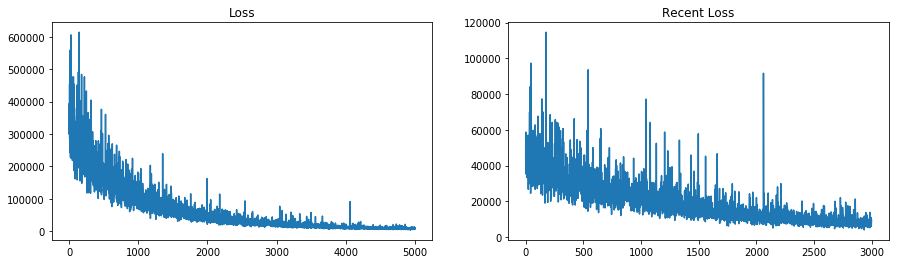

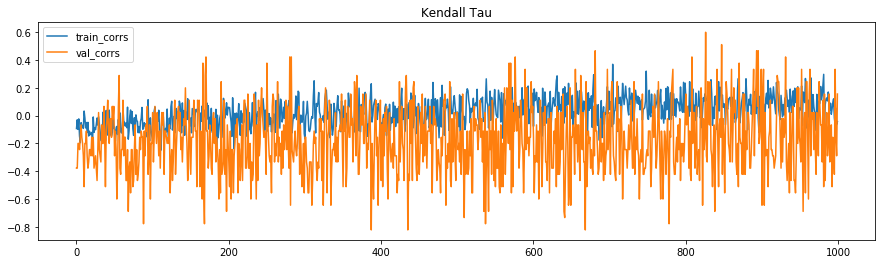

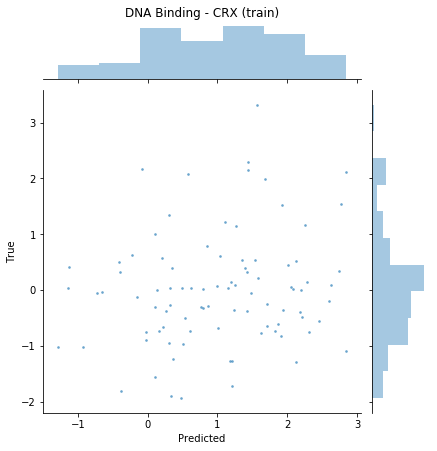

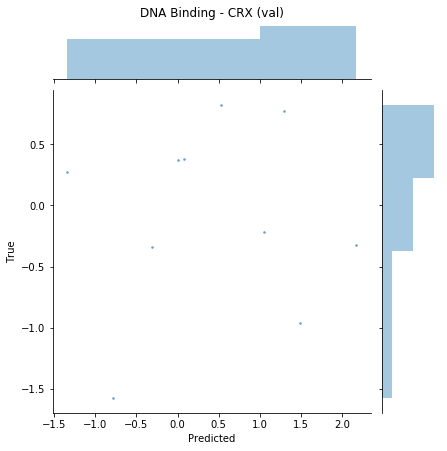

In [10]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(train_losses)
plt.title("Loss")

plt.subplot(122)
plt.plot(train_losses[-3000:])
plt.title("Recent Loss")

plt.figure(figsize=(15, 4))

# plt.subplot(121)
# plt.plot(mses)
# plt.title("MSE")

# plt.subplot(122)
plt.plot(train_corrs, label="train_corrs")
plt.plot(val_corrs, label="val_corrs")
plt.legend()
plt.title("Kendall Tau");
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

title = "DNA Binding - CRX"
train_title = title + " (train)"
val_title = title + " (val)"

if n_train > 1:
    preds = bnn_predict(guide, train_inputs, n_samples=100).mean(axis=0)
    jointplot(preds, train_labels, train_title)
    print('train_corrcoef:', np.corrcoef(preds, train_labels)[0, 1])

preds = bnn_predict(guide, val_inputs, n_samples=100).mean(axis=0)
jointplot(preds, val_labels, val_title);

print('val_corrcoef:', np.corrcoef(preds, val_labels)[0, 1])